In [12]:
import numpy as np
import pandas as pd
from scipy.signal import welch
import matplotlib.pyplot as plt

def extract_features(segments, fs=1000, threshold=0.01, wamp_threshold=0.05,
                     window_stride=0.2, start_time=0.0, plot_feature=None):
    '''
    Compute sEMG time- and frequency-domain features for each window and
    return a full feature tensor with timestamps for ML use.

    Parameters
    ----------
    segments : np.ndarray or list[np.ndarray]
        Either:
            - 2D array (n_channels, n_samples): single continuous signal split internally, OR
            - list of 1D sEMG windows (each window pre-segmented).
    fs : int
        Sampling frequency (Hz).
    threshold : float
        Threshold for zero crossings / slope sign changes.
    wamp_threshold : float
        Threshold for Willison Amplitude.
    window_stride : float
        Time between consecutive windows (s).
    start_time : float
        Timestamp of first window.
    plot_feature : str or None
        If provided, plots this feature (e.g. 'RMS') vs. time.

    Returns
    -------
    feature_tensor : np.ndarray
        (n_windows, n_features) array of feature values.
    feature_df : pd.DataFrame
        Feature DataFrame with timestamps.
    timestamps : np.ndarray
        Center time of each window.
    '''

    # --- Helper for per-window feature extraction ---
    def compute_window_features(x):
        x = np.asarray(x).flatten()
        dx = np.diff(x)

        # --- Time domain ---
        RMS  = np.sqrt(np.mean(x ** 2))
        MAV  = np.mean(np.abs(x))
        IEMG = np.sum(np.abs(x))
        WL   = np.sum(np.abs(np.diff(x)))
        VAR  = np.var(x)
        ZC   = np.sum(((x[:-1] * x[1:]) < 0) & (np.abs(x[:-1] - x[1:]) > threshold))
        SSC  = np.sum(((dx[:-1] * dx[1:]) < 0) & (np.abs(dx[:-1] - dx[1:]) > threshold))
        WAMP = np.sum(np.abs(dx) > wamp_threshold)

        # --- Frequency domain ---
        f, Pxx = welch(x, fs=fs, nperseg=min(256, len(x)))
        Pxx = Pxx / np.sum(Pxx + 1e-12)
        MNF = np.sum(f * Pxx)
        cumulative_power = np.cumsum(Pxx)
        MDF = f[np.where(cumulative_power >= 0.5)[0][0]]
        SEN = -np.sum(Pxx * np.log2(Pxx + 1e-12))
        TP  = np.sum(Pxx)

        return {
            'RMS': RMS, 'MAV': MAV, 'IEMG': IEMG, 'WL': WL, 'VAR': VAR,
            'ZC': ZC, 'SSC': SSC, 'WAMP': WAMP,
            'MNF': MNF, 'MDF': MDF, 'SEN': SEN, 'TP': TP
        }

    # --- Handle input shape ---
    if isinstance(segments, np.ndarray) and segments.ndim == 2:
        # If continuous data provided (n_channels, n_samples), assume already windowed externally
        segments = [segments[i, :] for i in range(segments.shape[0])]
    elif isinstance(segments, np.ndarray) and segments.ndim == 1:
        segments = [segments]  # single window

    # --- Extract features per window ---
    feature_list = []
    timestamps = []

    for i, seg in enumerate(segments):
        feats = compute_window_features(seg)
        feature_list.append(feats)
        timestamps.append(start_time + i * window_stride)

    # --- Assemble into DataFrame and Tensor ---
    feature_df = pd.DataFrame(feature_list)
    feature_df['timestamp'] = timestamps
    feature_df = feature_df[['timestamp'] + [c for c in feature_df.columns if c != 'timestamp']]

    feature_tensor = feature_df.drop(columns=['timestamp']).to_numpy()
    timestamps = np.array(timestamps)

    # --- Optional plotting ---
    if plot_feature is not None and plot_feature in feature_df.columns:
        plt.figure(figsize=(8, 4))
        plt.plot(feature_df['timestamp'], feature_df[plot_feature], '-o')
        plt.title(f'{plot_feature} Feature Trajectory')
        plt.xlabel('Time (s)')
        plt.ylabel(plot_feature)
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return feature_tensor, feature_df, timestamps


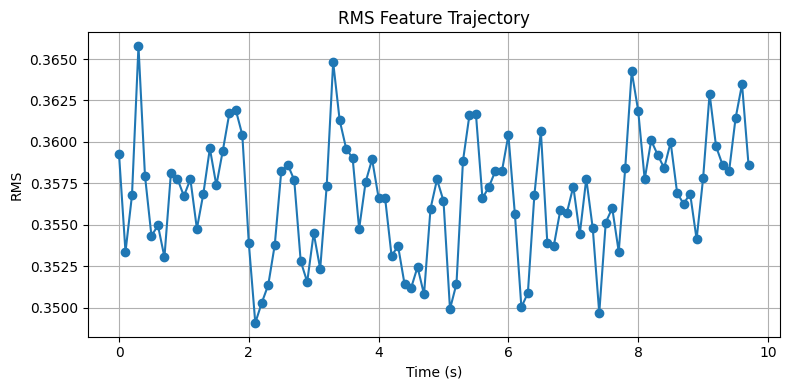

Feature tensor shape: (98, 12)
   timestamp       RMS       MAV       IEMG         WL       VAR  ZC  SSC  \
0        0.0  0.359270  0.323065  64.613007  22.361269  0.129034  20   54   
1        0.1  0.353363  0.318484  63.696834  21.615732  0.124862  20   40   
2        0.2  0.356780  0.320220  64.043945  21.598218  0.127196  20   42   
3        0.3  0.365777  0.327819  65.563869  22.755435  0.133769  19   54   
4        0.4  0.357966  0.320560  64.111953  22.313104  0.128138  20   52   

   WAMP        MNF   MDF       SEN   TP  
0   148  53.892410  50.0  1.456996  1.0  
1   138  54.637674  50.0  1.516734  1.0  
2   145  54.253273  50.0  1.466036  1.0  
3   159  53.928791  50.0  1.457029  1.0  
4   156  53.815709  50.0  1.484389  1.0  


In [13]:
# Simulated 10-second sEMG-like signal
fs = 1000
t = np.linspace(0, 10, 10_000)
emg = 0.5*np.sin(2*np.pi*50*t) + 0.05*np.random.randn(len(t))

# Segment into 200 ms windows with 50% overlap
win_len = int(0.2 * fs)
stride = int(0.1 * fs)
segments = [emg[i:i+win_len] for i in range(0, len(emg)-win_len, stride)]

# Extract all features and plot RMS over time
feature_tensor, feature_df, timestamps = extract_features(
    segments, fs=fs, window_stride=stride/fs, plot_feature='RMS'
)

print("Feature tensor shape:", feature_tensor.shape)
print(feature_df.head())


Tensor shape: (98, 12)
           count        mean           std         min         25%  \
timestamp   98.0    4.850000  2.843413e+00    0.000000    2.425000   
RMS         98.0    0.356761  3.608522e-03    0.349080    0.354176   
MAV         98.0    0.319798  3.373471e-03    0.311501    0.317351   
IEMG        98.0   63.959655  6.746942e-01   62.300177   63.470243   
WL          98.0   21.929407  4.260040e-01   21.119166   21.649402   
VAR         98.0    0.127279  2.572328e-03    0.121855    0.125439   
ZC          98.0   19.438776  6.432252e-01   19.000000   19.000000   
SSC         98.0   48.071429  6.282442e+00   34.000000   44.000000   
WAMP        98.0  150.979592  4.608329e+00  138.000000  148.000000   
MNF         98.0   53.946750  5.883904e-01   52.666144   53.541523   
MDF         98.0   50.000000  0.000000e+00   50.000000   50.000000   
SEN         98.0    1.476637  2.868005e-02    1.413101    1.458288   
TP          98.0    1.000000  1.167374e-10    1.000000    1.000000 

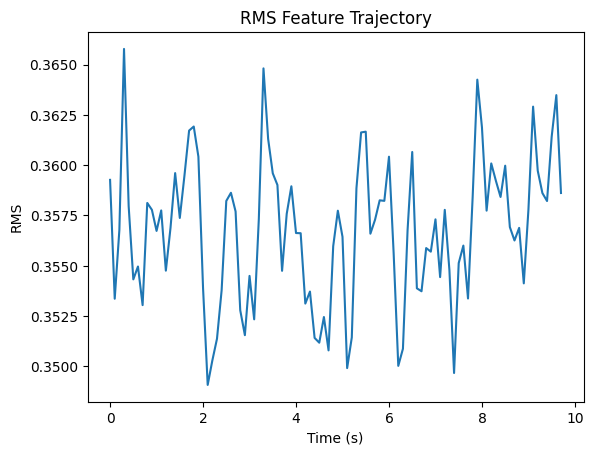

In [14]:
feature_tensor, feature_df, timestamps = extract_features(segments, fs=1000, window_stride=0.1)

# 2. Check shape consistency
print("Tensor shape:", feature_tensor.shape)
assert feature_tensor.ndim == 2
assert feature_tensor.shape[0] == len(segments)

# 3. Verify no NaNs or infs
assert np.isfinite(feature_tensor).all(), "Feature tensor contains NaNs or infs"

# 4. Verify column naming
expected_cols = ['timestamp','RMS','MAV','IEMG','WL','VAR','ZC','SSC','WAMP','MNF','MDF','SEN','TP']
assert list(feature_df.columns) == expected_cols, "Feature column names inconsistent"

# 5. Sanity check expected magnitudes
print(feature_df.describe().T)

# 6. Verify smooth trajectories visually
plt.plot(feature_df['timestamp'], feature_df['RMS'])
plt.xlabel('Time (s)')
plt.ylabel('RMS')
plt.title('RMS Feature Trajectory')
plt.show()